# **Trustworthy Machine Learning - XAI homework**


---
Group number ***Insert Here***

Student name #1 ***Insert Here***

Student name #2 ***Insert Here***

Student name #3 ***Insert Here***

**The deadline for this homework is on 12/12/2022 at 23:59.**

**Submission**: Please download your colab notebook as .ipynb and send it to [our email](mailto:stai.there@gmail.com). Make sure that you indicate your group number and names.

---
**Structure**: This homework is structured in 3 topics. Each topic corresponds the content of a separate lecture. We therefore recommend to only start working on each topic after attending the corresponding lecture. The recommended starting dates are indicated in the section headers, but feel free to explore by yourself, too.

You know the drill, save a copy of this notebook in your drive and work on it there!

For this homework, you also require some external python files and model checkpoints that are available [here](https://drive.google.com/drive/folders/187hr-TaeBCO6-t5ByiE5VSIl4XaLKgqw?usp=sharing). Make sure to download them to your drive and update the paths for import according throughout the notebook. **Do not use any other external libraries than the ones already defined in the notebook or consult the TML lecture staff first about usage.**

If you have any questions about the homework, feel free to drop us a message on Discord or come to the tutorials on Friday afternoon at 16:00. The lead tutor for this homework is [Elisa](mailto:elisa.nguyen@live.de). 

## **1. Introduction to explainability**
Recommended start: 18/11/2022

#### 1.1 XAI taxonomy
Explain the taxonomies of explainable AI methods. What does each category mean? Comment on the compatibility of the taxonomies. Give examples.

<img alt="XAI taxonomy" src="https://d3i71xaburhd42.cloudfront.net/21dff47a4142445f83016da0819ffe6dd2947f66/14-Figure7-1.png" width=400>

<font size=1>(Image source: Adadi and Berrada (2018), Scoop = Scope)</font>

<img alt="XAI problem taxonomy" src="https://www.researchgate.net/profile/Carla-Vieira-16/publication/341643347/figure/fig2/AS:895404656848907@1590492514543/Open-the-black-box-problems-taxonomy-Guidotti-et-al-2018.ppm" width=400>

<font size=1>(Image source: Guidotti et al. (2018))</font>

**ANSWER:**
XAI methods can be intrinsic or post-hoc:

Intrinsic Methods

### 1.2 "Good" explanations

State 3 aspects of good explanations and elaborate. Why are they important? How could they be evaluated (conceptual outline is sufficient)? 

**WRITE YOUR ANSWER HERE**

### 1.3 Explanation evaluation

Write a Python script for evaluating the correctness of a feature attribution explanation like saliency maps with a remove-and-classify approach. Since removing a feature at a time takes a long time, we instead remove 5% of the features in each removal step.

We provide a pre-trained LeNet model on Fashion-MNIST (~89% test set accuracy) with some dummy feature attribution explanations below. Please use these to test your remove-and-classify function.

In [132]:
# Set up GPU use in case it is available
import torch
import torchvision.transforms.functional as fn
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(2022)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# Here we load the pre-trained model
import sys
from lenet import LeNet

lenet = torch.load("lenet_fashionmnist.pckl", map_location=device)
lenet.eval()

LeNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): Linear(in_features=6272, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [3]:
# Loading the dataset. Since the model is already trained, we only require the test set.
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze())
                                ])

fmnist_test = datasets.FashionMNIST(root='./data_FashionMNIST',
                                train=False,
                                download=True,
                                transform=transform
                                )

In [4]:
import sys
sys.path.insert(0, 'xai_utils.py')
from xai_utils import model_accuracy

fmnist_accuracy = model_accuracy(lenet, fmnist_test)
assert fmnist_accuracy == 0.9
print(f'Accuracy on the test set: {fmnist_accuracy:.3f}')

Accuracy on the test set: 0.900


**Your turn! Fill in the function to evaluate how well the dummy gaussian maps explain the model predictions.**

In [55]:
# calculting the mean and std of the data
from torch.utils.data import DataLoader
dataloader = DataLoader(fmnist_test,batch_size=10000)
fashion_mean = next(iter(dataloader))[0].mean()[None]
fashion_std = next(iter(dataloader))[0].std()[None]
print("Fashion mean: ",fashion_mean)
print("Fashion std: ",fashion_std)

Fashion mean:  tensor([0.2868])
Fashion std:  tensor([0.3524])


In [173]:
# defining a custom dataset to apply transform to

from xai_utils import centered_gaussian
from torch.utils.data import Dataset

class RemovedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x,index)
        return x, y
        
    def __len__(self):
        return len(self.dataset)

class Remove(object):
    def __init__(self, k, fill='zero', explanations=None, mean=[0], std=[0]):
        
        #sort and flatten explinations bevorhand outside of loop
        #self.explanations = np.array([np.argsort(x.flatten()) for x in explanations])
        if( fill == 'mean' ): self.fill = 'm'
        elif( fill == 'noise' ): self.fill = 'n'
        else: self.fill = 'z'
        self.mean = mean
        self.std = std
        self.k = k
        self.explanations = explanations
        
    def __call__(self, sample_orig,index):
        #clone sample to not override original dataset
        sample = sample_orig.clone().detach()
        # mean fill
        if (self.fill == 'm'):
            for ind,m in enumerate(self.mean): 
                mask = self.explanations[index][-self.k:]
                if(self.mean.size()[0] == 1):      # if color image iterate through rgb channels
                    sample.flatten()[mask] = m   
                else:
                    sample[ind].flatten()[mask] = m   
        # noisy fill
        if (self.fill == 'n'):
            for ind,m in enumerate(self.mean):
                mask = self.explanations[index][-self.k:]
                if(self.mean.size()[0] == 1):
                    sample.flatten()[mask] = torch.normal(m, self.std[0], (self.k,))
                else:
                    sample[ind].flatten()[mask] = torch.normal(m, self.std[ind], (self.k,))
        # zero fill
        if (self.fill == 'z'):
            for ind,m in enumerate(self.mean): 
                mask = self.explanations[index][-self.k:]
                if(self.mean.size()[0] == 1):
                    sample.flatten()[mask] = 0.0 
                else:
                    sample[ind].flatten()[mask] = 0.0 
        return sample
        

In [170]:
from sklearn.metrics import auc
import torch
from tqdm import tqdm

def remove_and_classify(model, dataset, explanations, k=100, fill='zero',mean=0,std=0.0001):
    """Main remove and classify function. Iteratively removes top k features 
    from all instances in the dataset and measures model performance.
    Returns the list of model performance. 
    :param model: Model to explain
    :param dataset: Image data
    :param explanations: list of explanations corresponding to the dataset
    :param k: number of features to remove at once, initialized at 100
    :returns: list of model accuracy at removal of k features.
    """
    
    performances = []
    #### >>>> PUT YOUR SOLUTION HERE <<<< 
    for ks in range(k,dataset[0][0].shape[1]**2,k):
        transform_Remove = Remove(ks,explanations=explanations, fill=fill,mean=mean,std=std)
        removedData = RemovedDataset(dataset,transform=transform_Remove)
        performances.append(model_accuracy(model, removedData))
    #### >>>> END OF YOUR SOLUTION <<<<
    
    return performances

Run your evaluation code on the test set with the dummy explanations and get the removal performances. 
This takes about 1-3 minutes, depending on the GPU you were assigned.

In [171]:
import sys
sys.path.insert(0, 'xai_utils.py')
from xai_utils import centered_gaussian

explanations = np.array([np.argsort(centered_gaussian(28,28).flatten()) for x in explanations])

k = 100
removal_performances = remove_and_classify(lenet, fmnist_test, explanations, k, mean=fashion_mean, std=fashion_std/2) 
removal_performances.insert(0, fmnist_accuracy) # in place, adding the original accuracy in front for AUC 

# Mean Fill
removal_performances_mean = remove_and_classify(lenet, fmnist_test, explanations, 
                                                k, fill='mean', mean=fashion_mean, std=fashion_std/2) 
removal_performances_mean.insert(0, fmnist_accuracy) # in place, adding the original accuracy in front for AUC 
# Noise Fill
removal_performances_noise = remove_and_classify(lenet, fmnist_test, explanations, 
                                k, fill='noise', mean=fashion_mean, std=fashion_std/2) 
removal_performances_noise.insert(0, fmnist_accuracy) # in place, adding the original accuracy in front for AUC 

Text(0, 0.5, 'Noisy Fill')

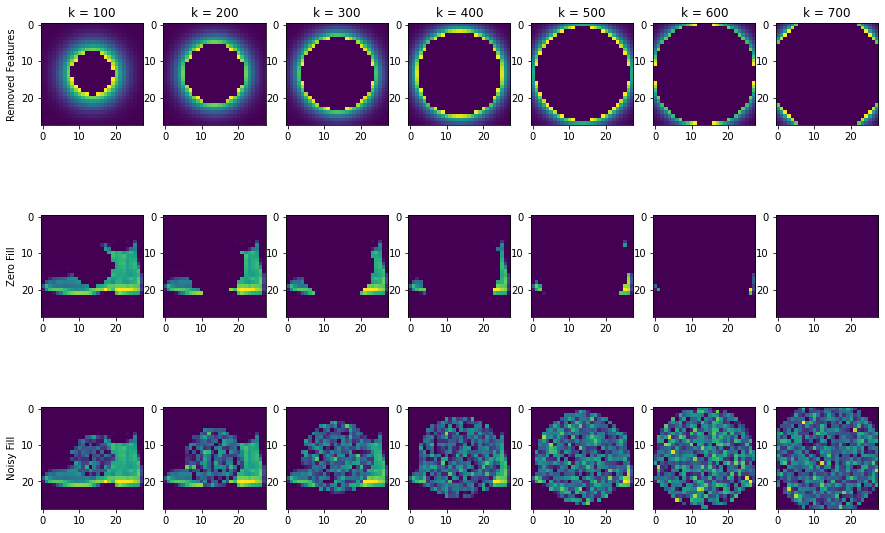

In [9]:
%matplotlib inline
plots = [[],[],[]]
all_the_ks = []
#### >>>> PUT YOUR SOLUTION HERE <<<< 
for ks in range(k,28*28,k):
    all_the_ks.append(ks)
    # mask
    gauss = explanations[0].flatten()
    gauss[np.argsort(gauss)[-ks:]] = 0
    reshaped_gauss = gauss.reshape(28,28)
    plots[0].append(reshaped_gauss)
    # zero fill
    transform_Cut = Cut(ks)
    cutFashion = CutDataset(fmnist_test,transform=transform_Cut)
    plots[1].append(cutFashion[0][0])
    # noise fill
    transform_Cut_mean = Cut(ks,fill='noise', mean=fashion_mean, std=fashion_std/2)
    cutFashion_mean = CutDataset(fmnist_test,transform=transform_Cut_mean)
    plots[2].append(cutFashion_mean[0][0])


fig, axs = plt.subplots(3,len(all_the_ks),figsize=(15,10))
for i,ks in enumerate(all_the_ks):
    axs[0][i].set_title("k = "+str(ks))
    for j in range(3):
        axs[j][i].imshow(plots[j][i])
axs[0][0].set_ylabel("Removed Features")
axs[1][0].set_ylabel("Zero Fill")
axs[2][0].set_ylabel("Noisy Fill")

The remove and classify score is  0.452
The remove and classify score for mean fill is  0.555
The remove and classify score for noisy fill is  0.570


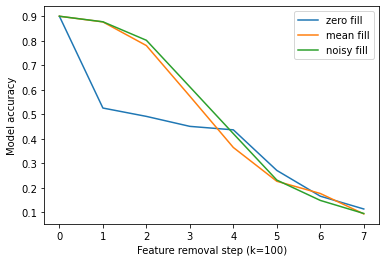

In [91]:
# To get the remove-and-classify score, get the AUC of the plot and plot the removal performances for analysis
import matplotlib.pyplot as plt
rac_score = auc(range(len(removal_performances)), removal_performances)
rac_score_norm = rac_score / auc(range(len(removal_performances)), [fmnist_accuracy]*len(removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}") 


rac_score = auc(range(len(removal_performances_mean)), removal_performances_mean)
rac_score_norm = rac_score / auc(range(len(removal_performances_mean)), [fmnist_accuracy]*len(removal_performances_mean))
print(f"The remove and classify score for mean fill is {rac_score_norm: .3f}") 


rac_score = auc(range(len(removal_performances_noise)), removal_performances_noise)
rac_score_norm = rac_score / auc(range(len(removal_performances_noise)), [fmnist_accuracy]*len(removal_performances_noise))
print(f"The remove and classify score for noisy fill is {rac_score_norm: .3f}") 

plt.plot(removal_performances, label="zero fill")
plt.plot(removal_performances_mean, label="mean fill")
plt.plot(removal_performances_noise, label="noisy fill")
plt.legend()
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=100)')
plt.show()

## **2. Explaining predictions with feature attribution**
Recommended start: 25/11/2022

### 2.1 CAM implementation

In this exercise, you will implement the feature attribution explanation method [CAM by Zhou et al. (2016)](http://ieeexplore.ieee.org/document/7780688/) in PyTorch using an already pre-trained ResNet50 on the image classification task of CUB, which is often used in XAI. CUB is a bird classification dataset with 200 classes of bird species. 

Additionally, you will also implement the vanilla gradient explanation method as a baseline to compare to.

We provide the model and model evaluation code below. Visualize your results with the provided method. 


First, we load the dataset and the model. As this is not a standard PyTorch dataset, we added a bit of functionality to it for our experiments. Loading the dataset takes a bit (loading roughly 3 min).

In [11]:
import sys
sys.path.insert(0, './xai_utils.py')
from xai_utils import load_cub_test, model_accuracy, centered_gaussian


cub_test = load_cub_test()
num_classes = 200 # 200 Bird species in CUB dataset


Files already downloaded and verified


In [160]:
from torch.utils.data import DataLoader
dataloader_cub = DataLoader(cub_test,batch_size=1000)
data = next(iter(dataloader_cub))[0]
cub_mean = data.mean(dim=[0,2,3]) 
cub_max = data.max()
cub_min = data.min()
cub_std = data.std(dim=[0,2,3])
print("CUB mean: ",cub_mean)
print("CUB min: ",cub_min)
print("CUB max: ",cub_max)
print("CUB std: ",cub_std)

CUB mean:  tensor([-0.0133,  0.1500,  0.0740])
CUB min:  tensor(-2.1179)
CUB max:  tensor(2.6400)
CUB std:  tensor([1.0022, 0.9990, 1.1549])


In [13]:
# # Check out Classes
# import pandas as pd
# import os

# image_class_labels = pd.read_csv(os.path.join("data", 'CUB_200_2011', 'classes.txt'),
#                                          sep=' ', names=['img_id', 'target'])
# print("Classes:")
# print(image_class_labels)

#### Load pre-trained ResNet50 with changed architecture in the last layers

Then, we load the model. It is a ResNet50 model that is pre-trained on the CUB dataset. 

**Important:** As mentioned during the lecture, there is an architectural change to the classic ResNet50 in the last layers in the provided model. Usually, a ResNet ends with a global average pooling layer before a dense layer, and then followed by a softmax. This is equivalent to changing the last layers to a 1x1 convolutional layer, global average pooling followed by softmax. With this architecture change, it is simpler to extract CAM. 

In [14]:
import sys
# sys.path.insert(0, './xai_utils.py')
from resnet50 import resnet50
resnet = resnet50(dataset_name='CUB',
                    pretrained=False,
                    num_classes=num_classes,
                    large_feature_map=False,
                    use_bn=True)
ckpt = torch.load("./cam_cub_checkpoint.pth.tar") 
resnet.load_state_dict(ckpt["state_dict"])
resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
cub_accuracy = model_accuracy(resnet, cub_test)
assert cub_accuracy == 0.799
print(f'Accuracy on the test set: {cub_accuracy:.3f}')

Accuracy on the test set: 0.799


Below, we provide the functions to show an image of the dataset and to visualize the feature attribution explanation as a heatmap overlay. Examples on how to use are also provided.

In [16]:
import sys
sys.path.insert(0, './xai_utils.py')
from xai_utils import show_sample, show_attribution_overlay

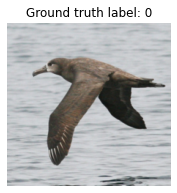

In [17]:
# Example. Visualizing the first test image.
%matplotlib inline 
show_sample(dataset=cub_test, sample_idx=0)

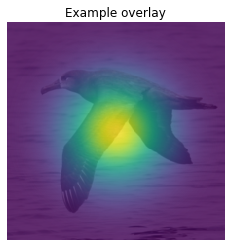

In [18]:
# Example. Visualizing the gaussian baseline as an attribution explanation overlay.
show_attribution_overlay(dataset=cub_test, 
                         sample_idx=0,
                         attribution_map=centered_gaussian(224,224),
                         title='Example overlay')

**Your turn! Write a function to extract CAM from the model to explain a certain prediction.**

#### Extract CAM from the ResNet50 model

In [146]:
def class_activation_map(model, dataset, sample_idx):
    """Gets the class activation map of the predicted class as a feature attribution explanation from the last convolutional layer of adapted ResNet model.
    Originally from Zhou et al. (2016)

    :param model: Adapted ResNet model in with 1x1 convolution
    :param dataset: dataset containing the instance to be explained 
    :param sample_idx: ID of the instance to be explained
    :returns: CAM of shape (224, 224) in case of CUB
    """
    # Tip: use the hook method to extract the activations of particular layers
    # Hook method below from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6 
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<< 
    model.conv_last.register_forward_hook(get_activation('conv_last'))
    output = model(dataset[sample_idx][0][None].to(device))
    
    # Set Class to explain. 0 for Black_footed_Albatross
    class_to_explain = output.argmax()
    cam = activation['conv_last'][0][class_to_explain][None]
    Resize = transforms.Resize(224)
    #### >>>> END OF YOUR SOLUTION <<<<
    return Resize(cam).cpu()

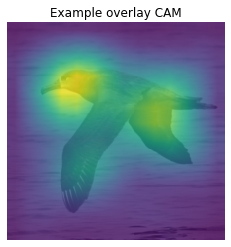

In [147]:
cam = class_activation_map(resnet, cub_test, 0)

show_attribution_overlay(dataset=cub_test, 
                         sample_idx=0,
                         attribution_map=cam.squeeze(),
                         title='Example overlay CAM')


**Your turn again! Write a function to get the saliency map from [Simonyan et al. (2013)](http://arxiv.org/abs/1312.6034) as a local explanation.**

In [148]:
def saliency(model, dataset, sample_idx):
    """Computes the saliency map of the predicted class as a feature attribution explanation. 
    From Simonyan et al. (2013)

    :param model: predictive model
    :param dataset: dataset containing the instance to be explained 
    :param sample_idx: ID of the instance to be explained
    :returns: saliency map of shape (224, 224) in case of CUB
    """
    # Tip: Look at the assumptions for RGB images in the paper.
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<< 
    x = dataset[sample_idx][0][None].to(device)
    x.requires_grad = True
    y = model(x)
    crossE = torch.nn.CrossEntropyLoss()
    # Set Class to explain. 0 for Black_footed_Albatross
    class_to_explain = 0
    target = torch.nn.functional.one_hot(torch.tensor([class_to_explain]),y.shape[1]).float().to(device)
    loss = crossE(y,target)
    loss.backward()
    x_grad = x.grad.squeeze()
    saliency = x_grad.max(dim=0)[0].cpu()
    #### >>>> END OF YOUR SOLUTION <<<<
    return saliency

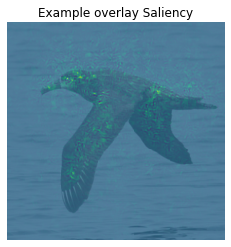

In [149]:
saliency_attribution = saliency(resnet, cub_test, 0)

show_attribution_overlay(dataset=cub_test, 
                         sample_idx=0,
                         attribution_map=saliency_attribution,
                         title='Example overlay Saliency')


### 2.2 Evaluate CAM
Evaluate the methods using the remove-and-classify approach from exercise 1.3 of this homework. You may need to adapt the remove-and-classify function to the CUB dataset, because it is not a standard PyTorch dataset (If you need help with this, please contact the tutors since coding this correctly is not the point of this exercise). Report the scores. 

In [150]:
from tqdm import tqdm

def get_explanations(explanation_function, model, dataset):
    """Computes the explanations for the whole dataset specified in dataset

    :param explanation_function: python function that takes arguments model, dataset, idx
    :param model: model to be explained
    :param dataset: dataset to be used to explain the model
    """
    explanations = []
    for idx in tqdm(range(len(dataset))):
        e = explanation_function(model, dataset, idx)
        explanations.append(e)
    return explanations

100%|██████████| 1000/1000 [00:13<00:00, 72.89it/s]


(zero)The remove and classify score is  0.100
(mean)The remove and classify score is  0.099
(noise)The remove and classify score is  0.080


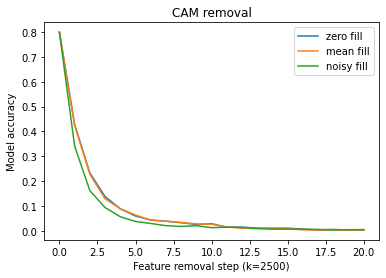

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline
# Evaluation of CAM
# First, get the explanations
cam_explanations = get_explanations(class_activation_map, resnet, cub_test)
cam_explanations = [np.argsort(x.flatten()) for x in cam_explanations]

# then remove-and-classify, this takes roughly 5-10 min depending on the GPU you got assigned from Colab
k = 2500
cam_removal_performances_zero = remove_and_classify(resnet, cub_test, cam_explanations, k,fill='zero',mean=cub_mean,std=cub_std)
cam_removal_performances_zero.insert(0, cub_accuracy)

cam_removal_performances_mean = remove_and_classify(resnet, cub_test, cam_explanations, k,fill='mean',mean=cub_mean,std=cub_std)
cam_removal_performances_mean.insert(0, cub_accuracy)

cam_removal_performances_noise = remove_and_classify(resnet, cub_test, cam_explanations, k,fill='noise',mean=cub_mean,std=cub_std)
cam_removal_performances_noise.insert(0, cub_accuracy)

# Inspect the results
rac_score = auc(range(len(cam_removal_performances_zero)), cam_removal_performances_zero)
rac_score_norm = rac_score / auc(range(len(cam_removal_performances_zero)), [cub_accuracy]*len(cam_removal_performances_zero))
print(f"(zero)The remove and classify score is {rac_score_norm: .3f}")
rac_score = auc(range(len(cam_removal_performances_mean)), cam_removal_performances_mean)
rac_score_norm = rac_score / auc(range(len(cam_removal_performances_mean)), [cub_accuracy]*len(cam_removal_performances_mean))
print(f"(mean)The remove and classify score is {rac_score_norm: .3f}") 
rac_score = auc(range(len(cam_removal_performances_noise)), cam_removal_performances_noise)
rac_score_norm = rac_score / auc(range(len(cam_removal_performances_noise)), [cub_accuracy]*len(cam_removal_performances_noise))
print(f"(noise)The remove and classify score is {rac_score_norm: .3f}")  

plt.plot(cam_removal_performances_zero,label="zero fill")
plt.plot(cam_removal_performances_mean,label="mean fill")
plt.plot(cam_removal_performances_noise,label="noisy fill")
plt.ylabel('Model accuracy')
plt.title("CAM removal")
plt.legend()
plt.xlabel('Feature removal step (k=2500)')
plt.show()

100%|██████████| 1000/1000 [00:26<00:00, 37.09it/s]


(zero)The remove and classify score is  0.074
(mean)The remove and classify score is  0.075
(noise)The remove and classify score is  0.044


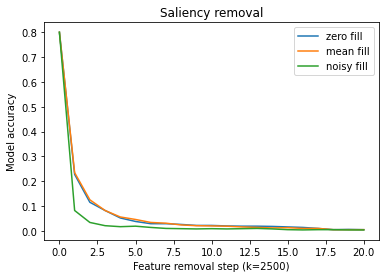

In [177]:
# Evaluation of saliency
# cub_test = load_cub_test()

# First, get the explanations
saliency_explanations = get_explanations(saliency, resnet, cub_test)
saliency_explanations_cub = [np.argsort(x.flatten()) for x in saliency_explanations]

# then remove-and-classify
k = 2500
saliency_removal_performances_zero = remove_and_classify(resnet, cub_test, saliency_explanations_cub, k,fill='zero',mean=cub_mean,std=cub_std)
saliency_removal_performances_zero.insert(0, cub_accuracy)

saliency_removal_performances_mean = remove_and_classify(resnet, cub_test, saliency_explanations_cub, k,fill='mean',mean=cub_mean,std=cub_std)
saliency_removal_performances_mean.insert(0, cub_accuracy)

saliency_removal_performances_noise = remove_and_classify(resnet, cub_test, saliency_explanations_cub, k,fill='noise',mean=cub_mean,std=cub_std)
saliency_removal_performances_noise.insert(0, cub_accuracy)


# Inspect the results
rac_score = auc(range(len(saliency_removal_performances_zero)), saliency_removal_performances_zero)
rac_score_norm = rac_score / auc(range(len(saliency_removal_performances_zero)), [cub_accuracy]*len(saliency_removal_performances_zero))
print(f"(zero)The remove and classify score is {rac_score_norm: .3f}") 
rac_score = auc(range(len(saliency_removal_performances_mean)), saliency_removal_performances_mean)
rac_score_norm = rac_score / auc(range(len(saliency_removal_performances_mean)), [cub_accuracy]*len(saliency_removal_performances_mean))
print(f"(mean)The remove and classify score is {rac_score_norm: .3f}") 
rac_score = auc(range(len(saliency_removal_performances_noise)), saliency_removal_performances_noise)
rac_score_norm = rac_score / auc(range(len(saliency_removal_performances_noise)), [cub_accuracy]*len(saliency_removal_performances_noise))
print(f"(noise)The remove and classify score is {rac_score_norm: .3f}") 


plt.plot(saliency_removal_performances_zero,label="zero fill")
plt.plot(saliency_removal_performances_mean,label="mean fill")
plt.plot(saliency_removal_performances_noise,label="noisy fill")
plt.legend()
plt.title("Saliency removal")
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=2500)')
plt.show()

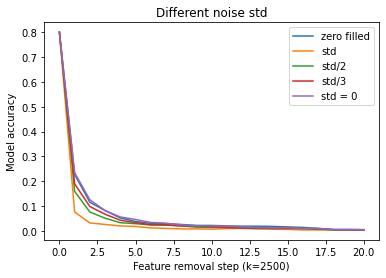

In [26]:
k = 2500

saliency_removal_performances_std2 = remove_and_classify(resnet, cub_test, saliency_explanations_cub, k,fill='noise',mean=cub_mean,std=np.array(cub_std)/2)
saliency_removal_performances_std2.insert(0, cub_accuracy)

saliency_removal_performances_std3 = remove_and_classify(resnet, cub_test, saliency_explanations_cub, k,fill='noise',mean=cub_mean,std=np.array(cub_std)/3)
saliency_removal_performances_std3.insert(0, cub_accuracy)


plt.plot(saliency_removal_performances_zero,label="zero filled")
plt.plot(saliency_removal_performances_noise,label="std")
plt.plot(saliency_removal_performances_std2,label="std/2")
plt.plot(saliency_removal_performances_std3,label="std/3")
plt.plot(saliency_removal_performances_mean,label="std = 0")
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=2500)')
plt.legend()
plt.title("Different noise std")
plt.show()

(zero) The remove and classify score is  0.252
(mean) The remove and classify score is  0.262
(noise)The remove and classify score is  0.215


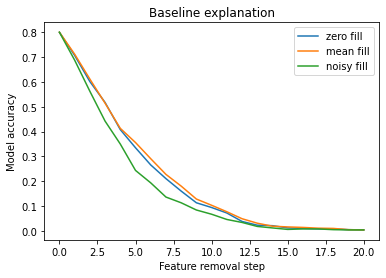

In [178]:
# Evaluation of gaussian map baseline
# cub_test = load_cub_test()
# First, get the explanations
baseline_explanations = np.array([np.argsort(centered_gaussian(224,224).flatten())]*len(cub_test))
 
# then remove-and-classify
k = 2500
baseline_removal_performances_zero = remove_and_classify(resnet, cub_test, baseline_explanations, k,fill='zero',mean=cub_mean,std=cub_std)
baseline_removal_performances_zero.insert(0, cub_accuracy)
baseline_removal_performances_mean = remove_and_classify(resnet, cub_test, baseline_explanations, k,fill='mean',mean=cub_mean,std=cub_std)
baseline_removal_performances_mean.insert(0, cub_accuracy)
baseline_removal_performances_noise = remove_and_classify(resnet, cub_test, baseline_explanations, k,fill='noise',mean=cub_mean,std=cub_std)
baseline_removal_performances_noise.insert(0, cub_accuracy)


# Inspect the results
rac_score = auc(range(len(baseline_removal_performances_zero)), baseline_removal_performances_zero)
rac_score_norm = rac_score / auc(range(len(baseline_removal_performances_zero)), [cub_accuracy]*len(baseline_removal_performances_zero))
print(f"(zero) The remove and classify score is {rac_score_norm: .3f}") 
rac_score = auc(range(len(baseline_removal_performances_mean)), baseline_removal_performances_mean)
rac_score_norm = rac_score / auc(range(len(baseline_removal_performances_mean)), [cub_accuracy]*len(baseline_removal_performances_mean))
print(f"(mean) The remove and classify score is {rac_score_norm: .3f}") 
rac_score = auc(range(len(baseline_removal_performances_noise)), baseline_removal_performances_noise)
rac_score_norm = rac_score / auc(range(len(baseline_removal_performances_noise)), [cub_accuracy]*len(baseline_removal_performances_noise))
print(f"(noise)The remove and classify score is {rac_score_norm: .3f}") 


plt.plot(baseline_removal_performances_zero,label="zero fill")
plt.plot(baseline_removal_performances_mean,label="mean fill")
plt.plot(baseline_removal_performances_noise,label="noisy fill")
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step')
plt.legend()
plt.title("Baseline explanation")
plt.show()

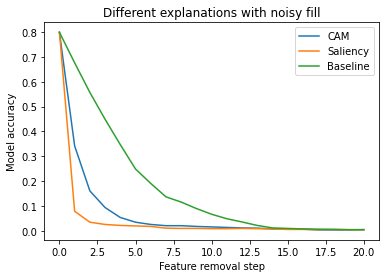

In [163]:
plt.plot(cam_removal_performances_noise,label="CAM")
plt.plot(saliency_removal_performances_noise,label="Saliency")
plt.plot(baseline_removal_performances_noise,label="Baseline")
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step')
plt.legend()
plt.title("Different explanations with noisy fill")
plt.show()

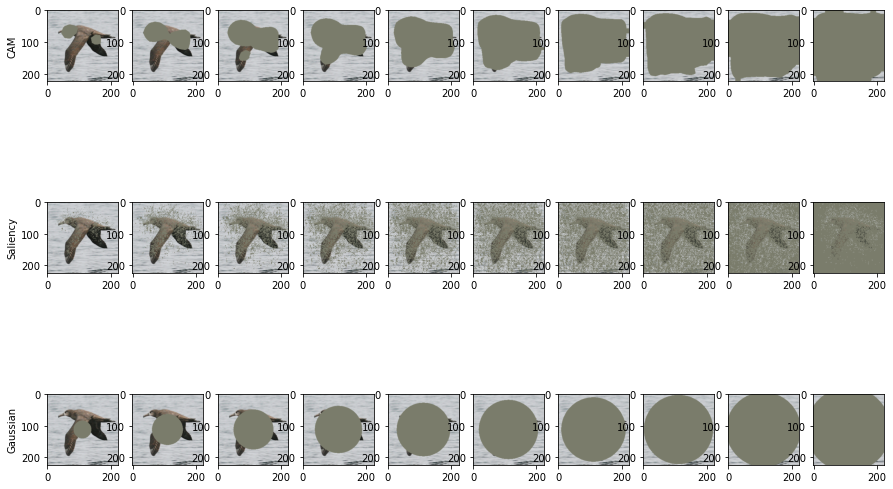

In [175]:
%matplotlib inline
plots = [[],[],[]]
all_the_ks = []
index = 0
#### >>>> PUT YOUR SOLUTION HERE <<<< 
for ks in range(k,224*224,k):
    all_the_ks.append(ks)
    # gauss
    transform_Remove = Remove(ks,explanations=cam_explanations, fill='mean',mean=cub_mean,std=np.array(cub_std))
    RemovedData = RemovedDataset(cub_test,transform=transform_Remove)
    plots[0].append(RemovedData[index][0])
    # cam
    transform_Remove = Remove(ks,explanations=saliency_explanations_cub, fill='mean',mean=cub_mean,std=np.array(cub_std))
    RemovedData = RemovedDataset(cub_test,transform=transform_Remove)
    plots[1].append(RemovedData[index][0])
    # sal
    transform_Remove = Remove(ks,explanations=baseline_explanations, fill='mean',mean=cub_mean,std=np.array(cub_std))
    RemovedData = RemovedDataset(cub_test,transform=transform_Remove)
    plots[2].append(RemovedData[index][0])

unnormalize_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
    std = [ 1., 1., 1. ]),
])
    
fig, axs = plt.subplots(3,len(all_the_ks)//2,figsize=(15,10))
for i in range(0,len(all_the_ks),2):
    ks = all_the_ks[i]
    for j in range(3):
        axs[j][i//2].imshow(unnormalize_transform(plots[j][i]).permute(1,2,0))
axs[2][0].set_ylabel("Gaussian")
axs[0][0].set_ylabel("CAM")
axs[1][0].set_ylabel("Saliency")
plt.show()

### 2.3 Discussion
Briefly discuss your experimental results, both from visual inspection and the quantitative analysis. What does the evaluation say about CAM? What could be limitations of the remove-and-classify approach, too? Does it make sense to e.g. weight different parts of the AUC differently?

**Answer:** We compared different feature attribution explanations by evaluating their explanatory power with an remove-and-classify approach. We also studied the effect of differnt ways of removing features. A steep decline in accuracy if one removes the explanation features, implies that these features capture the reasons a netork came to a certain decision.

Looking at fashion Mnist with a gaussian shaped explanation, one notices that removing the features by replacing them with a value of 0, similar to the background, results in a stronger decrease in accuracy, than replacing them with a mean value. While a mean value is often considered as carring less information, in the case of Mnist the non informative background has always a value of 0 whereas a pixel value near the mean is always part of an object. Filling pixels inside the centered objects with a mean value is therefore not synonymous with removing them.

In the case of the CUB dataset, the zero value is very close to the mean value. We additionally tested removing features by filling them with random values drawn from a normal distribution with the dataset mean and std. This filling regime leads to a lowest AUC for all methods: In the case of saliency removal filling with noise lowers the AUC by a factor of 1.7 and for CAM by 1.25.

Overall the saliency methods achieves the lowest AUC with 0.044, followed by CAM with AUC=0.08. The baseline gaussian explanation has a AUC of 0.215 .

This means that the pointwise saliency explanation describes the decision process of the NN better than the areal CAM.
But the remove and classify approach is not perfect. We saw that it is not clear what values actually remove the information of the features. A CAM implementation with a noisy fill is almost as good as a saliency approach with a mean fill.
Furthermore, the remove and classify approach is very compute intensive.

The most important part of the AUC is the beginning. If a explanation finds the most important features, its ROC curve will decreaase very steeply. 

**WRITE YOUR ANSWER HERE**

In [ ]:
# Remove all defined variables from memory for the next exercise 
# from https://www.skillsugar.com/how-to-delete-variables-functions-from-memory-in-python
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

del element

## **3. Explaining a model with feature visualization**
Recommended start: 2/12/2022

###3.1 Feature visualization implementation

In this exercise, you are going to implement feature visualization of features learned by neurons of a Googlenet model. For regularization we will use the total variation regularizer from [Mahendran and Vevaldi (2014)](http://arxiv.org/abs/1412.0035). Beware that their paper is not about feature visualization, but about image reconstruction.

Feature visualization is an optimization problem, where we are optimising an input image to maximize the activation of certain units in the inference model. These units can be single neurons, but also convolutional filters.

Try different starting images (e.g. random noise, any image) and feel free to play around with the resulting visualizations.


In [43]:
# First, we load the inference model from the PyTorch Hub
torch.manual_seed(2022)

In [44]:
# We do a small change to the forward method of the model, by adding a clamp.
# This keeps the input image in a valid range
import torch.nn as nn
class MyGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

    def forward(self, x):
        x = torch.clamp(x, 0, 1)
        x = self.googlenet(x)
        return x

In [45]:
net = MyGoogLeNet().to(device)
net.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to C:\Users\lenna/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\lenna/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

MyGoogLeNet(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [46]:
# We provide a simple visualization function of the image 
import matplotlib.pyplot as plt

def visualize(x):
    """Function to visualize x (detached from comp graph) with plt
    """
    x = x.cpu()
    x = x.permute(1,2,0) # switch dimensions to bring RGB to back
    plt.imshow(x)

In [47]:
# We require the Hook method below to specify which network unit to target in the visualization.
# Code from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6 

# In contrast to the hook method used to compute CAM in exercise 2, here we do not detach the activation because we require it for optimization
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# YOUR TURN: try out different channels/layers/units/etc. You can take inspiration from 
# https://distill.pub/2017/feature-visualization/appendix/googlenet/4b.html#channel-4 
# a whole inception layer
net.googlenet.inception4a.register_forward_hook(get_activation('4a'))
# one convolutional layer of the inception layer
net.googlenet.inception4a.branch1.conv.register_forward_hook(get_activation('4a1conv'))
# the final layer
net.googlenet.fc.register_forward_hook(get_activation('fc'))

**Your turn! Take a look at the code below and complete it to optimize the input image for high activation of the unit.**

In [48]:
from torch.optim import Adam

# start with random image
x = torch.rand((3,224,224), requires_grad=True, device=device) # We want to optimize x to maximize the activation 

optimizer = Adam([x], lr=0.01) # optimize the image
num_epochs = 500
x_prog = {} # To store the optimized images

for step in range(num_epochs):
    optimizer.zero_grad()

    # run the model on the input
    net(x.unsqueeze(0)) # unsqueeze to simulate the batch

    # get the activation of a unit
    neuron_activation = # PUT YOUR ANSWER HERE

    # log progress
    if step % 50 == 0:
        print(f'Mean activation in Step {step}: {torch.mean(neuron_activation): .3f}')
        x_prog[step] = torch.clamp(x,0,1).clone().detach()

    # define the loss 
    loss = # PUT YOUR ANSWER HERE

    # Backpropagate and optimization
    loss.backward()
    optimizer.step()

SyntaxError: invalid syntax (Temp/ipykernel_14180/1136539163.py, line 17)

In [ ]:
# Visualize the progressions

plt.figure(figsize=(20,8))

for i, key in enumerate(x_prog.keys()):
    plt.subplot(2,5,i+1)
    visualize(x_prog[key])
    plt.title(f'After {key} iterations')

Let's add the total variation regularizer and see what happens. 

In [ ]:
# YOUR TURN! PUT YOUR ANSWER HERE
def total_variation_regularizer(x, beta):
    pass

In [ ]:
# Run another optimization
x = torch.rand((3,224,224), requires_grad=True, device=device) 

optimizer = Adam([x], lr=0.01) # optimize the image
num_epochs = 1000
x_prog_tv = {} # To store the optimized images

for step in range(num_epochs):
    optimizer.zero_grad()

    # run the model on the input
    net(x.unsqueeze(0)) # unsqueeze to simulate the batch

    # get the activation of a unit
    neuron_activation = # PUT YOUR ANSWER HERE (same as above)

    # log progress
    if step % 100 == 0:
        print(f'Mean activation in Step {step}: {torch.mean(neuron_activation): .3f}')
        x_prog_tv[step] = torch.clamp(x, 0, 1).clone().detach()

    # define the loss 
    loss = # PUT YOUR ANSWER HERE (with TV regularization)

    # Backpropagate and optimization
    loss.backward()
    optimizer.step()

In [ ]:
# Visualize the progressions

plt.figure(figsize=(20,8))

for i, key in enumerate(x_prog_tv.keys()):
    plt.subplot(2,5,i+1)
    visualize(x_prog_tv[key])
    plt.title(f'After {key} iterations')

###3.2 Discussion

Discuss your observations from the feature visualizations. 
- What is the effect of the total variation regularization? Does it make sense?

- What kind of insights do feature visualizations give into the model? How general are these insights? 

- Where could such explanations be used? 


**WRITE YOUR ANSWER HERE**

## **4. (Bonus) Short Paper Review**

In this bonus task, your task is to write a short review for **one** of the following papers: 
- [THIS LOOKS LIKE IT RATHER THAN THAT: PROTOKNN FOR SIMILARITY-BASED CLASSIFIERS](https://openreview.net/forum?id=lh-HRYxuoRr). 
- [TAKE 5: INTERPRETABLE IMAGE CLASSIFICATION WITH A HANDFUL OF FEATURES](https://openreview.net/forum?id=9EcAsB7wgM)
- [ViT-CX: Causal Explanation of Vision Transformers](http://arxiv.org/abs/2211.03064)

Below is are a few questions to consider in a review as inspiration (Slightly adapted from [ICML'22 reviewer guide](https://drive.google.com/file/d/15hPTA64h31ShaoybLWeU3moZan7zVbr_/view))
- A concise summary of the paper
    - What problem is addressed in the paper?
    - Why does the problem matter?
    - What is the key to the solution? What is the main contribution?
    - Do the experiments sufficiently support the claims?
- A clear statement of strengths and weaknesses
    - What are the key contributions and why do they matter?
    - What aspects of the paper most need improvement?
- A comprehensive check of potential fundamental flaws in the paper
    - Are the assumptions and theories (mathematically) sound?
    - Are the experiments scientifically sound and valid?
    - Is the problem addressed trivial?


**WRITE YOUR ANSWER HERE**